In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from bs4 import BeautifulSoup as bs
import pickle
import re
from matplotlib import pyplot as plt
import ImprovedOSMToGraph as mkgraph
import xml.sax
import copy
import networkx
import scipy.spatial as spa
import time
import numpy.linalg as nla
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
seattle = pd.read_csv("Cleaned_Seattle.csv")
baton = pd.read_csv("Cleaned_Baton.csv")
bloom = pd.read_csv("Cleaned_Bloom.csv")

In [4]:
def load_graph(filename):
    with open(filename, 'rb') as file:
        graph = pickle.load(file)
    return graph

seattle_graph = load_graph("seattle_graph")
baton_graph = load_graph("baton_rouge_graph")
bloom_graph = load_graph("bloomington_graph")


In [5]:
#first, let's insert a "NODE" column 
seattle["NODE"] = np.zeros_like(np.array(seattle["LATITUDE"]))
baton["NODE"] = np.zeros_like(np.array(baton["LATITUDE"]))
bloom["NODE"] = np.zeros_like(np.array(bloom["LATITUDE"]))

In [6]:
#gather node data from the graph
def extract_node_data(graph):
    """
    Extracts data from NetworkX graph
    
    Parameters:
    
        graph: networkX graph of road structure
    
    Output:
        
        node_ids: list of ids contained in the graph
        node_lons: list of longitudes of the nodes in the graph (with identical ordering to node_ids)
        node_lats: list of latitudes of the nodes in the graph (with identical ordering to node_ids)
        node_tags: list of tags attached to nodes in the graph (identical ordering to node_ids)
    
    """
    node_ids = list(graph.nodes())
    node_lons = []
    node_lats = []
    node_tags = []
    for node_id in node_ids:
        node_lons.append(graph.node[node_id]['lon'])
        node_lats.append(graph.node[node_id]['lat'])
        node_tags.append(graph.node[node_id]['tags'])

    return node_ids, node_lons, node_lats, node_tags

In [7]:
def build_dict(node_ids, node_lats, node_lons):
    """
    Builds a dictionary with key: node_id, value: [latitude, longitude]
    
    parameters: 
        node_ids: list of node ids
        node_lats: list of latitudes, identical ordering to node_ids
        node_lons: list of longitudes, identical ordering to node_ids
        
    output:
        node_dict: dictionary of node_ids linked to lat/long coordinates
    """
    node_dict = {}
    for i in range(len(node_ids)):
        node_dict[node_lats[i], node_lons[i]] = node_ids[i]
    return node_dict

In [8]:
def find_matches(crash_data, node_lats, node_lons, node_dict):
    """
    Uses a KDTree to match the nodes from the networkx graph to the accidents from the crash data.
    
    Parameters:
        crash_data: Pandas dataframe with accident data in the Seattle area
        node_lats: list of latitudes of nodes in the seattle area
        node_lons: list of longitudes of nodes in the seattle area
        node_dict: dictionary of nodes / node lat&lons
    Output:
        matches: list of node_ids, ordered to the accidents in crash_data
        tree: the KDTree created
    """
    #make a tree of the nodes, organize crash data
    c_lats = list(crash_data["LATITUDE"])
    c_lons = list(crash_data["LONGITUDE"])
    c_pairs = np.array([c_lats,c_lons])
    n_pairs = np.array([node_lats,node_lons])
    
    #Build the tree out of the nodes, based on lat/lon
    print("Node pairs: ", n_pairs.shape)
    tree = spa.KDTree(n_pairs.T)
    
    #match up the pairs
    matches = []
    start = time.time()
    print("Crash Pairs: ", c_pairs.shape)
    #for every crash_pair, find the nearest node_pair.
    for i in range(c_pairs.shape[1]):
        pair = c_pairs[:,i]
        d, locs = tree.query(pair)
        m_pair = tree.data[locs]
        matches.append(node_dict[m_pair[0],m_pair[1]])
    
    print("Time: ", time.time() - start)
    
    return matches, tree

### Seattle

In [9]:
#apply the above functions, add the nodes_ids to the seattle df
s_node_ids, s_node_lons, s_node_lats, sea_tags = extract_node_data(seattle_graph)
node_dict = build_dict(s_node_ids, s_node_lats, s_node_lons)
matches, seattle_tree = find_matches(seattle, s_node_lats, s_node_lons)
seattle["NODE"] = matches

Node pairs:  (2, 201620)
Crash Pairs:  (2, 197775)
Time:  31.11015796661377


Matched Nodes:  21301
201620


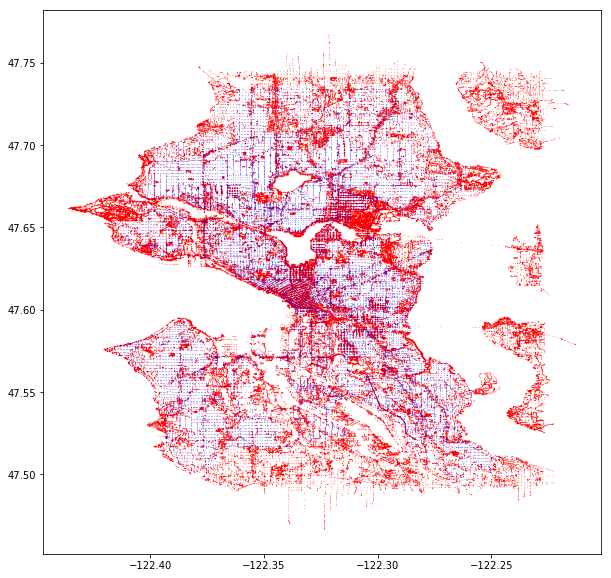

In [25]:
#seattle.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", s=.01, figsize=(10,10),c='b')

#graph the nodes of seattle, with the nodes tied to accidents in red

nodes_with_crashes = set(matches)
print("Matched Nodes: ", len(nodes_with_crashes))

excluded_nodes = []
excluded_node_lats = []
excluded_node_lons = []
inc_node_lats = []
inc_node_lons = []
inc_nodes = []
print(len(s_node_ids))
count = 0
for nid in s_node_ids:
    if nid not in nodes_with_crashes:
        excluded_nodes.append(nid)
        excluded_node_lons.append(seattle_graph.node[nid]['lon'])
        excluded_node_lats.append(seattle_graph.node[nid]['lat'])
    else:
        inc_nodes.append(nid)
        inc_node_lons.append(seattle_graph.node[nid]['lon'])
        inc_node_lats.append(seattle_graph.node[nid]['lat'])
    count += 1
plt.figure(figsize=(10,10))
plt.scatter(excluded_node_lons, excluded_node_lats, s=.01, c='r')
plt.scatter(inc_node_lons, inc_node_lats, s=.01, c='b')
plt.show()

### Baton Rouge

In [91]:
bat_node_ids, bat_node_lons, bat_node_lats, bat_tags = extract_node_data(baton_graph)
node_dict = build_dict(bat_node_ids, bat_node_lats, bat_node_lons)
matches, baton_tree = find_matches(baton, bat_node_lats, bat_node_lons)
baton["NODE"] = matches

Node pairs:  (2, 64660)
Crash Pairs:  (2, 113014)
Time:  20.045963525772095


### Bloom

In [92]:
blo_node_ids, blo_node_lons, blo_node_lats, blo_tags = extract_node_data(bloom_graph)
node_dict = build_dict(blo_node_ids, blo_node_lats, blo_node_lons)
matches, bloom_tree = find_matches(bloom, blo_node_lats, blo_node_lons)
bloom["NODE"] = matches


Node pairs:  (2, 108041)
Crash Pairs:  (2, 48910)
Time:  10.023257732391357


In [104]:
seattle.to_csv("Featured_Seattle.csv")
baton.to_csv("Featured_Baton.csv")
bloom.to_csv("Featured_Bloom.csv")